# Brent Oil Price Analysis - Exploratory Data Analysis
## Task 1: Data Understanding and Preparation

**Date:** $(Get-Date -Format 'yyyy-MM-dd')
**Author:** Data Science Team
**Purpose:** Initial exploration of Brent oil price data and geopolitical events

### 1. Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### 2. Load and Inspect Brent Oil Data

In [3]:
# Load Brent oil price data
brent_data = pd.read_csv('../data/raw/BrentOilPrices.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {brent_data.shape}")
print(f"Date Range: {brent_data['Date'].min()} to {brent_data['Date'].max()}")
print("\nFirst 5 rows:")
display(brent_data.head())

print("\n=== DATA INFORMATION ===")
print(brent_data.info())

print("\n=== DESCRIPTIVE STATISTICS ===")
display(brent_data.describe())

print("\n=== MISSING VALUES ===")
print(brent_data.isnull().sum())

=== DATASET OVERVIEW ===
Dataset Shape: (9011, 2)
Date Range: 01-Apr-02 to Sep 30, 2022

First 5 rows:


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63



=== DATA INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None

=== DESCRIPTIVE STATISTICS ===


,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000



=== MISSING VALUES ===
Date     0
Price    0
dtype: int64


### 3. Data Cleaning and Preparation

In [12]:
# Convert Date to datetime
print("Converting Date column to datetime format...")

# Try multiple date formats - your data might use different format
try:
    # Try the format you specified
    brent_data['Date'] = pd.to_datetime(brent_data['Date'], format='%d-%b-%y')
    print("✓ Date converted using format '%d-%b-%y'")
except:
    try:
        # Try another common format
        brent_data['Date'] = pd.to_datetime(brent_data['Date'], format='%Y-%m-%d')
        print("✓ Date converted using format '%Y-%m-%d'")
    except:
        try:
            # Try day-first format
            brent_data['Date'] = pd.to_datetime(brent_data['Date'], format='%d/%m/%Y')
            print("✓ Date converted using format '%d/%m/%Y'")
        except:
            # Let pandas infer the format
            brent_data['Date'] = pd.to_datetime(brent_data['Date'])
            print("✓ Date converted using pandas inference")

# Fix year 2000 issues
def fix_year(date):
    try:
        if date.year > 2023:  # If year appears as 2087 instead of 1987
            return date.replace(year=date.year - 100)
        return date
    except:
        return date

brent_data['Date'] = brent_data['Date'].apply(fix_year)

# Sort by date
brent_data = brent_data.sort_values('Date').reset_index(drop=True)

# Check the date range
print(f"\nDate range after conversion: {brent_data['Date'].min()} to {brent_data['Date'].max()}")
print(f"Date format examples:")
print(brent_data['Date'].head(3).tolist())

# Check for duplicates
duplicates = brent_data.duplicated().sum()
print(f"\nDuplicate rows found: {duplicates}")

# Check for missing values in Price column
print(f"\n=== MISSING VALUES ANALYSIS ===")
print(f"Missing values in Price: {brent_data['Price'].isnull().sum()}")
print(f"Missing values in Date: {brent_data['Date'].isnull().sum()}")

# Handle missing values
missing_before = brent_data['Price'].isnull().sum()
if missing_before > 0:
    print(f"\nInterpolating {missing_before} missing values...")
    brent_data['Price'] = brent_data['Price'].interpolate(method='linear')
    # Forward/backward fill any remaining NaNs at edges
    brent_data['Price'] = brent_data['Price'].fillna(method='ffill').fillna(method='bfill')
    missing_after = brent_data['Price'].isnull().sum()
    print(f"Missing values after interpolation: {missing_after}")

# Set Date as index for time series analysis
brent_data.set_index('Date', inplace=True)

print("\n=== CLEANED DATA INFO ===")
print(f"Final date range: {brent_data.index.min()} to {brent_data.index.max()}")
print(f"Total trading days: {len(brent_data)}")
print(f"Number of years covered: {(brent_data.index.max() - brent_data.index.min()).days / 365:.1f}")
print(f"Average price: ${brent_data['Price'].mean():.2f}")
print(f"Price range: ${brent_data['Price'].min():.2f} - ${brent_data['Price'].max():.2f}")
print(f"Standard deviation: ${brent_data['Price'].std():.2f}")

# Check for zeros or negative prices (data quality check)
zero_or_negative = (brent_data['Price'] <= 0).sum()
if zero_or_negative > 0:
    print(f"WARNING: Found {zero_or_negative} prices ≤ 0")

# Display sample of data
print(f"\n=== SAMPLE DATA (First 5 rows) ===")
print(brent_data.head())

print(f"\n=== SAMPLE DATA (Last 5 rows) ===")
print(brent_data.tail())

Converting Date column to datetime format...
✓ Date converted using pandas inference

Date range after conversion: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Date format examples:
[Timestamp('1987-05-20 00:00:00'), Timestamp('1987-05-21 00:00:00'), Timestamp('1987-05-22 00:00:00')]

Duplicate rows found: 0

=== MISSING VALUES ANALYSIS ===
Missing values in Price: 0
Missing values in Date: 0

=== CLEANED DATA INFO ===
Final date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total trading days: 9011
Number of years covered: 35.5
Average price: $48.42
Price range: $9.10 - $143.95
Standard deviation: $32.86

=== SAMPLE DATA (First 5 rows) ===
            Price  Log_Price   Returns  Log_Returns  Abs_Returns
Date                                                            
1987-05-20  18.63   2.924773       NaN          NaN          NaN
1987-05-21  18.45   2.915064 -0.966184    -0.970881     0.970881
1987-05-22  18.55   2.920470  0.542005     0.540542     0.540542
1987-05-25  18.60   2.92

### 4. Load and Prepare Event Data

In [13]:
# Load your event data
events_data = pd.read_csv('../data/events/geopolitical_events.csv')
events_data['date'] = pd.to_datetime(events_data['date'])

print("=== EVENT DATA OVERVIEW ===")
print(f"Number of events: {len(events_data)}")
print(f"Event date range: {events_data['date'].min()} to {events_data['date'].max()}")

print("\n=== EVENT DISTRIBUTION ===")
print("\nBy Event Type:")
print(events_data['event_type'].value_counts())

print("\nBy Impact Level:")
print(events_data['impact_level'].value_counts())

print("\nBy Region:")
print(events_data['region'].value_counts())

print("\n=== EVENT LIST ===")
display(events_data.sort_values('date'))

=== EVENT DATA OVERVIEW ===
Number of events: 12
Event date range: 1990-08-02 00:00:00 to 2022-02-24 00:00:00

=== EVENT DISTRIBUTION ===

By Event Type:
event_type
Conflict           8
Disaster           1
Economic Crisis    1
Policy             1
Health/Policy      1
Name: count, dtype: int64

By Impact Level:
impact_level
High      10
Medium     2
Name: count, dtype: int64

By Region:
region
Middle East       5
Global            4
USA               1
Europe/Ukraine    1
Europe            1
Name: count, dtype: int64

=== EVENT LIST ===


,date,event_name,event_type,region,impact_level,description
0,1990-08-02,Iraq Invades Kuwait,Conflict,Middle East,High,Iraq invades Kuwait triggering Gulf War
1,1991-01-17,Operation Desert Storm,Conflict,Middle East,High,Coalition military action affecting oil produc...
2,2003-03-20,Iraq War Begins,Conflict,Middle East,High,US-led invasion impacting oil supply
3,2005-08-29,Hurricane Katrina,Disaster,USA,Medium,Hurricane disrupts Gulf of Mexico oil production
4,2008-09-15,Lehman Brothers Collapse,Economic Crisis,Global,High,Global financial crisis affecting oil demand
5,2011-02-11,Arab Spring Begins,Conflict,Middle East,Medium,Political instability in key oil-producing cou...
6,2014-03-16,Crimea Annexation,Conflict,Europe/Ukraine,High,Russia annexes Crimea affecting geopolitical risk
7,2016-11-30,OPEC Production Cut,Policy,Global,High,OPEC announces coordinated production cut
8,2019-09-14,Saudi Oil Facility Attacks,Conflict,Middle East,High,Drone attacks reduce Saudi oil production sign...
9,2020-03-09,Oil Price War Begins,Conflict,Global,High,Saudi-Russia price war triggers market crash


### 5. Time Series Analysis: Trends and Patterns

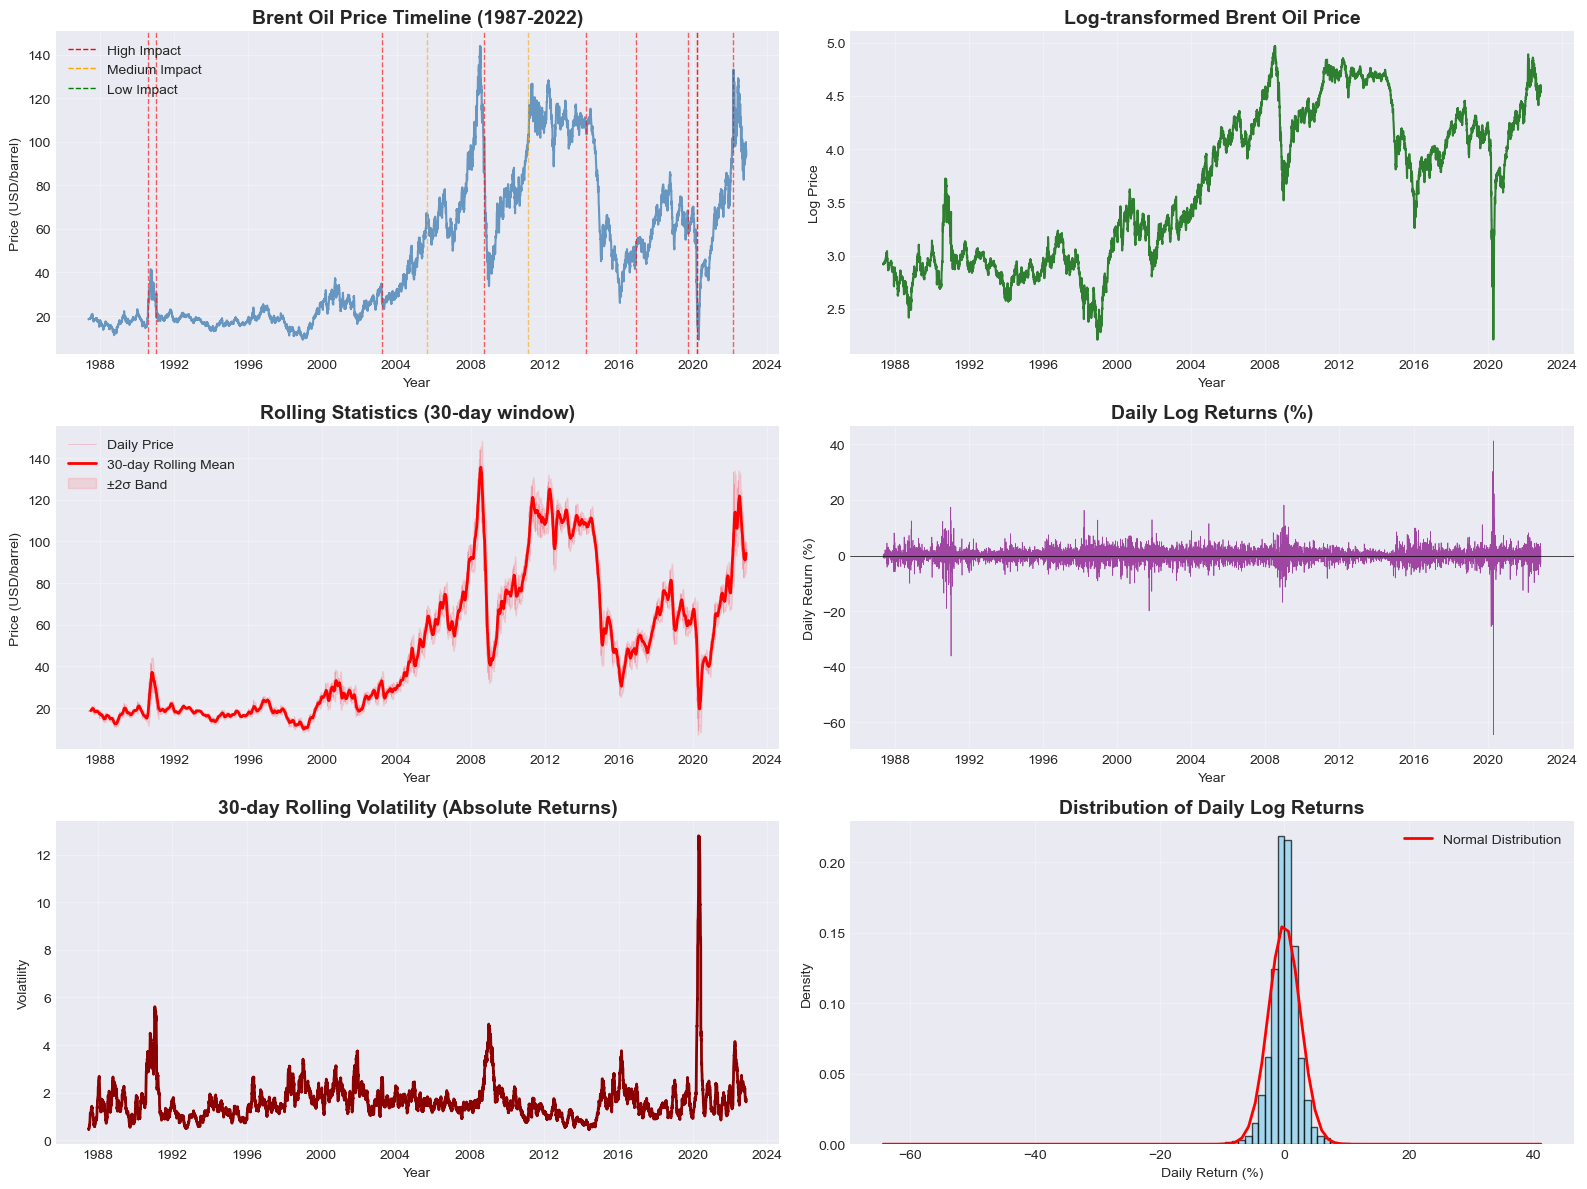

In [14]:
# Create a comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Raw price series with events
ax1 = plt.subplot(3, 2, 1)
ax1.plot(brent_data.index, brent_data['Price'], linewidth=1.5, color='steelblue', alpha=0.8)
ax1.set_title('Brent Oil Price Timeline (1987-2022)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price (USD/barrel)')
ax1.grid(True, alpha=0.3)

# Add event markers
colors = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}
for idx, event in events_data.iterrows():
    ax1.axvline(x=event['date'], 
                color=colors.get(event['impact_level'], 'gray'), 
                alpha=0.6, 
                linestyle='--', 
                linewidth=1)

# Create legend for event types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='High Impact'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=1, label='Medium Impact'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=1, label='Low Impact')
]
ax1.legend(handles=legend_elements, loc='upper left')

# 2. Log transformation for better visualization
ax2 = plt.subplot(3, 2, 2)
brent_data['Log_Price'] = np.log(brent_data['Price'])
ax2.plot(brent_data.index, brent_data['Log_Price'], linewidth=1.5, color='darkgreen', alpha=0.8)
ax2.set_title('Log-transformed Brent Oil Price', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Log Price')
ax2.grid(True, alpha=0.3)

# 3. Rolling statistics
ax3 = plt.subplot(3, 2, 3)
rolling_mean = brent_data['Price'].rolling(window=30).mean()
rolling_std = brent_data['Price'].rolling(window=30).std()
ax3.plot(brent_data.index, brent_data['Price'], label='Daily Price', alpha=0.5, linewidth=0.5)
ax3.plot(brent_data.index, rolling_mean, label='30-day Rolling Mean', color='red', linewidth=2)
ax3.fill_between(brent_data.index, 
                 rolling_mean - 2*rolling_std, 
                 rolling_mean + 2*rolling_std, 
                 color='red', alpha=0.1, label='±2σ Band')
ax3.set_title('Rolling Statistics (30-day window)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Price (USD/barrel)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Returns analysis
ax4 = plt.subplot(3, 2, 4)
brent_data['Returns'] = brent_data['Price'].pct_change() * 100
brent_data['Log_Returns'] = np.log(brent_data['Price'] / brent_data['Price'].shift(1)) * 100
ax4.plot(brent_data.index, brent_data['Log_Returns'], linewidth=0.5, color='purple', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_title('Daily Log Returns (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Daily Return (%)')
ax4.grid(True, alpha=0.3)

# 5. Volatility clustering (absolute returns)
ax5 = plt.subplot(3, 2, 5)
brent_data['Abs_Returns'] = brent_data['Log_Returns'].abs()
rolling_volatility = brent_data['Abs_Returns'].rolling(window=30).mean()
ax5.plot(brent_data.index, rolling_volatility, linewidth=2, color='darkred')
ax5.set_title('30-day Rolling Volatility (Absolute Returns)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Year')
ax5.set_ylabel('Volatility')
ax5.grid(True, alpha=0.3)

# 6. Distribution of returns
ax6 = plt.subplot(3, 2, 6)
returns_clean = brent_data['Log_Returns'].dropna()
ax6.hist(returns_clean, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Add normal distribution for comparison
from scipy.stats import norm
x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
ax6.plot(x, norm.pdf(x, returns_clean.mean(), returns_clean.std()), 
         'r-', linewidth=2, label='Normal Distribution')
ax6.set_title('Distribution of Daily Log Returns', fontsize=14, fontweight='bold')
ax6.set_xlabel('Daily Return (%)')
ax6.set_ylabel('Density')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Stationarity Testing

In [15]:
print("=== STATIONARITY ANALYSIS ===\n")

# Test raw price series
print("1. Testing Raw Price Series:")
result_raw = adfuller(brent_data['Price'].dropna())
print(f"   ADF Statistic: {result_raw[0]:.4f}")
print(f"   p-value: {result_raw[1]:.4f}")
print(f"   Critical Values:")
for key, value in result_raw[4].items():
    print(f"     {key}: {value:.4f}")
if result_raw[1] < 0.05:
    print("   Conclusion: Stationary (reject null hypothesis)")
else:
    print("   Conclusion: Non-stationary (fail to reject null hypothesis)")

# Test log price series
print("\n2. Testing Log Price Series:")
result_log = adfuller(brent_data['Log_Price'].dropna())
print(f"   ADF Statistic: {result_log[0]:.4f}")
print(f"   p-value: {result_log[1]:.4f}")
if result_log[1] < 0.05:
    print("   Conclusion: Stationary (reject null hypothesis)")
else:
    print("   Conclusion: Non-stationary (fail to reject null hypothesis)")

# Test log returns
print("\n3. Testing Log Returns:")
result_returns = adfuller(brent_data['Log_Returns'].dropna())
print(f"   ADF Statistic: {result_returns[0]:.4f}")
print(f"   p-value: {result_returns[1]:.4f}")
if result_returns[1] < 0.05:
    print("   Conclusion: Stationary (reject null hypothesis)")
else:
    print("   Conclusion: Non-stationary (fail to reject null hypothesis)")

=== STATIONARITY ANALYSIS ===

1. Testing Raw Price Series:
   ADF Statistic: -1.9939
   p-value: 0.2893
   Critical Values:
     1%: -3.4311
     5%: -2.8619
     10%: -2.5669
   Conclusion: Non-stationary (fail to reject null hypothesis)

2. Testing Log Price Series:
   ADF Statistic: -1.8089
   p-value: 0.3761
   Conclusion: Non-stationary (fail to reject null hypothesis)

3. Testing Log Returns:
   ADF Statistic: -16.4271
   p-value: 0.0000
   Conclusion: Stationary (reject null hypothesis)


### 7. Autocorrelation Analysis

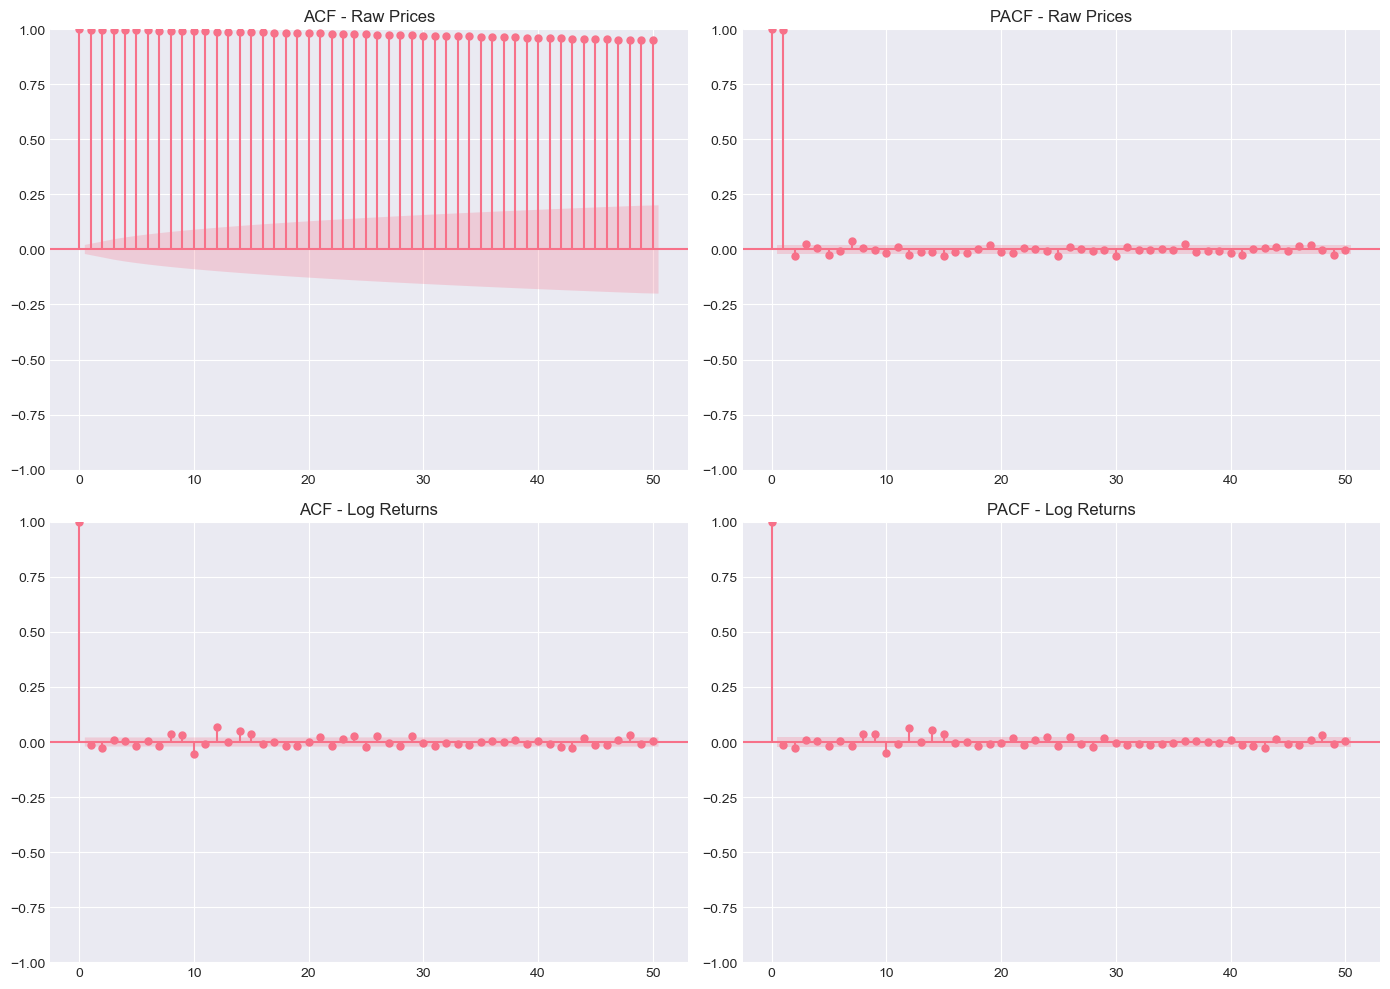

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF and PACF of raw prices
plot_acf(brent_data['Price'].dropna(), lags=50, ax=axes[0, 0], title='ACF - Raw Prices')
plot_pacf(brent_data['Price'].dropna(), lags=50, ax=axes[0, 1], title='PACF - Raw Prices')

# ACF and PACF of log returns
plot_acf(brent_data['Log_Returns'].dropna(), lags=50, ax=axes[1, 0], title='ACF - Log Returns')
plot_pacf(brent_data['Log_Returns'].dropna(), lags=50, ax=axes[1, 1], title='PACF - Log Returns')

plt.tight_layout()
plt.show()

### 8. Event Impact Analysis

In [16]:
print("=== EVENT IMPACT PRELIMINARY ANALYSIS ===\n")

# Function to analyze price changes around events
def analyze_event_impact(event_date, days_before=30, days_after=30):
    """Analyze price behavior around an event"""
    start_date = event_date - pd.Timedelta(days=days_before)
    end_date = event_date + pd.Timedelta(days=days_after)
    
    # Get price data around event
    event_window = brent_data.loc[start_date:end_date].copy()
    
    if len(event_window) < 10:
        return None
    
    # Calculate metrics
    price_before = event_window.loc[:event_date]['Price'].mean()
    price_after = event_window.loc[event_date:]['Price'].mean()
    price_change_pct = ((price_after - price_before) / price_before) * 100
    
    max_price = event_window['Price'].max()
    min_price = event_window['Price'].min()
    volatility = event_window['Returns'].std()
    
    return {
        'price_before': price_before,
        'price_after': price_after,
        'price_change_pct': price_change_pct,
        'max_price': max_price,
        'min_price': min_price,
        'volatility': volatility,
        'window_size': len(event_window)
    }

# Analyze each event
event_impacts = []
for idx, event in events_data.iterrows():
    impact = analyze_event_impact(event['date'])
    if impact:
        event_impacts.append({
            'event_name': event['event_name'],
            'date': event['date'],
            'event_type': event['event_type'],
            'impact_level': event['impact_level'],
            **impact
        })

# Create DataFrame
impact_df = pd.DataFrame(event_impacts)

print("Event Impact Summary:")
display(impact_df.sort_values('price_change_pct', ascending=False))

print("\n=== SUMMARY STATISTICS ===")
print(f"Average price change across all events: {impact_df['price_change_pct'].mean():.2f}%")
print(f"Maximum price increase: {impact_df['price_change_pct'].max():.2f}%")
print(f"Maximum price decrease: {impact_df['price_change_pct'].min():.2f}%")
print(f"Average volatility during event windows: {impact_df['volatility'].mean():.4f}")

=== EVENT IMPACT PRELIMINARY ANALYSIS ===

Event Impact Summary:


,event_name,date,event_type,impact_level,price_before,price_after,price_change_pct,max_price,min_price,volatility,window_size
0,Iraq Invades Kuwait,1990-08-02,Conflict,High,17.586957,27.496364,56.345207,32.35,14.98,4.223615,44
11,Russia-Ukraine War,2022-02-24,Conflict,High,95.485652,115.881818,21.360451,133.18,89.49,3.971752,44
7,OPEC Production Cut,2016-11-30,Policy,High,44.797826,53.053333,18.428366,54.97,41.61,2.819184,43
5,Arab Spring Begins,2011-02-11,Conflict,Medium,98.515909,110.039500,11.697188,116.89,96.04,1.675239,41
8,Saudi Oil Facility Attacks,2019-09-14,Conflict,High,60.372727,61.687143,2.177168,68.42,57.37,2.914823,43
3,Hurricane Katrina,2005-08-29,Disaster,Medium,63.746190,63.390435,-0.558081,67.26,60.04,2.079979,43
6,Crimea Annexation,2014-03-16,Conflict,High,108.961000,106.410000,-2.341205,111.26,103.37,0.961058,42
4,Lehman Brothers Collapse,2008-09-15,Economic Crisis,High,105.595500,88.343478,-16.337838,117.24,66.86,3.604427,42
2,Iraq War Begins,2003-03-20,Conflict,High,32.826522,26.056364,-20.624050,34.94,24.39,2.865292,44
1,Operation Desert Storm,1991-01-17,Conflict,High,26.718571,20.588182,-22.944302,30.28,18.35,7.325520,42



=== SUMMARY STATISTICS ===
Average price change across all events: -4.85%
Maximum price increase: 56.35%
Maximum price decrease: -53.12%
Average volatility during event windows: 4.3814


### 9. Visualize Event Impacts

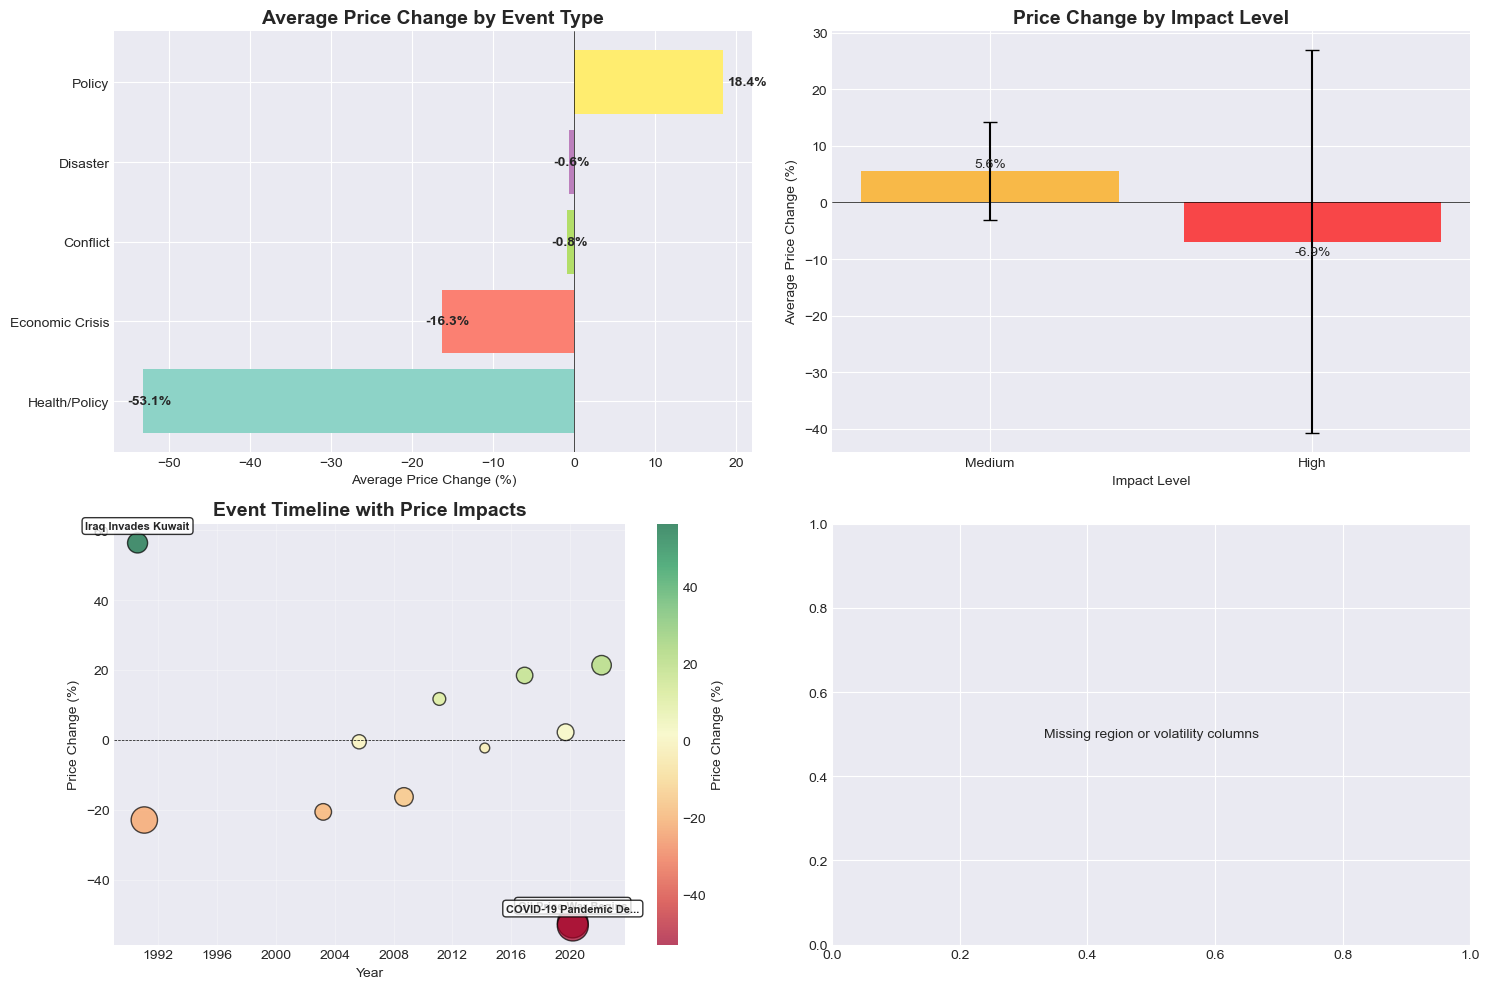

In [20]:
# Create event impact visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Check if impact_df has data
if impact_df.empty or len(impact_df) == 0:
    print("No event impact data available. Skipping visualizations.")
    plt.close()
else:
    # 1. Price change by event type
    ax1 = axes[0, 0]
    
    # Check if required columns exist
    if 'event_type' in impact_df.columns and 'price_change_pct' in impact_df.columns:
        event_type_impact = impact_df.groupby('event_type')['price_change_pct'].mean().sort_values()
        
        if len(event_type_impact) > 0:
            colors = plt.cm.Set3(np.linspace(0, 1, len(event_type_impact)))
            bars = ax1.barh(event_type_impact.index, event_type_impact.values, color=colors)
            ax1.set_title('Average Price Change by Event Type', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Average Price Change (%)')
            ax1.axvline(x=0, color='black', linewidth=0.5)
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                label_x = width + (0.5 if width >= 0 else -2)
                ax1.text(label_x, 
                         bar.get_y() + bar.get_height()/2,
                         f'{width:.1f}%', 
                         va='center', 
                         fontweight='bold')
        else:
            ax1.text(0.5, 0.5, 'No event type data', 
                    ha='center', va='center', transform=ax1.transAxes)
    else:
        ax1.text(0.5, 0.5, 'Missing event_type or price_change_pct columns', 
                ha='center', va='center', transform=ax1.transAxes)
    
    # 2. Price change by impact level
    ax2 = axes[0, 1]
    
    if 'impact_level' in impact_df.columns and 'price_change_pct' in impact_df.columns:
        impact_level_order = ['Low', 'Medium', 'High']
        
        # Filter to only include existing impact levels
        existing_levels = impact_df['impact_level'].unique()
        impact_level_order = [level for level in impact_level_order if level in existing_levels]
        
        if len(impact_level_order) > 0:
            impact_level_avg = impact_df.groupby('impact_level')['price_change_pct'].mean().reindex(impact_level_order)
            impact_level_std = impact_df.groupby('impact_level')['price_change_pct'].std().reindex(impact_level_order)
            
            x_pos = range(len(impact_level_avg))
            
            # Define colors based on impact level
            color_map = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
            bar_colors = [color_map.get(level, 'gray') for level in impact_level_order]
            
            bars = ax2.bar(x_pos, impact_level_avg.values, 
                           yerr=impact_level_std.values if not impact_level_std.isnull().all() else None, 
                           capsize=5, 
                           color=bar_colors,
                           alpha=0.7)
            ax2.set_title('Price Change by Impact Level', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Impact Level')
            ax2.set_ylabel('Average Price Change (%)')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(impact_level_order)
            ax2.axhline(y=0, color='black', linewidth=0.5)
            
            # Add value labels on bars
            for i, (bar, value) in enumerate(zip(bars, impact_level_avg.values)):
                height = bar.get_height()
                label_y = height + (0.2 if height >= 0 else -0.8)
                ax2.text(bar.get_x() + bar.get_width()/2, label_y,
                        f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
        else:
            ax2.text(0.5, 0.5, 'No valid impact level data', 
                    ha='center', va='center', transform=ax2.transAxes)
    else:
        ax2.text(0.5, 0.5, 'Missing impact_level or price_change_pct columns', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # 3. Timeline of events with price changes
    ax3 = axes[1, 0]
    
    if all(col in impact_df.columns for col in ['date', 'price_change_pct', 'volatility', 'event_name']):
        # Convert date to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(impact_df['date']):
            impact_df['date'] = pd.to_datetime(impact_df['date'])
        
        # Check if we have numeric data
        if pd.api.types.is_numeric_dtype(impact_df['price_change_pct']):
            # Normalize volatility for bubble sizes (avoid division by zero)
            if impact_df['volatility'].max() > impact_df['volatility'].min():
                normalized_volatility = (impact_df['volatility'] - impact_df['volatility'].min()) / \
                                      (impact_df['volatility'].max() - impact_df['volatility'].min())
                bubble_sizes = 50 + normalized_volatility * 450  # Size range: 50-500
            else:
                bubble_sizes = 100  # Default size
            
            scatter = ax3.scatter(impact_df['date'], impact_df['price_change_pct'], 
                                c=impact_df['price_change_pct'], 
                                cmap='RdYlGn', 
                                s=bubble_sizes, 
                                alpha=0.7, 
                                edgecolors='black')
            
            ax3.set_title('Event Timeline with Price Impacts', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Price Change (%)')
            ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
            ax3.grid(True, alpha=0.3)
            
            # Add colorbar
            plt.colorbar(scatter, ax=ax3, label='Price Change (%)')
            
            # Add event labels for major impacts
            for idx, row in impact_df.iterrows():
                if abs(row['price_change_pct']) > impact_df['price_change_pct'].abs().quantile(0.75):  # Top 25%
                    ax3.annotate(row['event_name'][:20] + ('...' if len(row['event_name']) > 20 else ''), 
                                (row['date'], row['price_change_pct']),
                                textcoords="offset points",
                                xytext=(0, 10),
                                ha='center',
                                fontsize=8,
                                fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        else:
            ax3.text(0.5, 0.5, 'price_change_pct is not numeric', 
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        ax3.text(0.5, 0.5, 'Missing required timeline columns', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # 4. Volatility by region
    ax4 = axes[1, 1]
    
    if 'region' in impact_df.columns and 'volatility' in impact_df.columns:
        region_volatility = impact_df.groupby('region')['volatility'].mean().sort_values(ascending=False)
        
        if len(region_volatility) > 0:
            bars = ax4.bar(range(len(region_volatility)), region_volatility.values, 
                          color=plt.cm.tab20c(np.linspace(0, 1, len(region_volatility))))
            ax4.set_title('Average Volatility by Region', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Region')
            ax4.set_ylabel('Volatility (std of returns)')
            ax4.set_xticks(range(len(region_volatility)))
            ax4.set_xticklabels(region_volatility.index, rotation=45, ha='right')
            
            # Add value labels on top of bars
            for i, (bar, value) in enumerate(zip(bars, region_volatility.values)):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{value:.4f}', ha='center', va='bottom', fontsize=9)
        else:
            ax4.text(0.5, 0.5, 'No region data available', 
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        ax4.text(0.5, 0.5, 'Missing region or volatility columns', 
                ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()

### 10. Key Insights and Findings

In [22]:
print("=== KEY INSIGHTS FROM EDA ===\n")

# 1. DATA QUALITY
print("1. DATA QUALITY:")
print(f"   • Total observations: {len(brent_data):,}")

try:
    if hasattr(brent_data.index.min(), 'date'):
        print(f"   • Date range: {brent_data.index.min().date()} to {brent_data.index.max().date()}")
    else:
        print(f"   • Date range: {brent_data.index.min()} to {brent_data.index.max()}")
except:
    print("   • Date range: Unable to determine")

# Check for Price column
if 'Price' in brent_data.columns:
    print(f"   • Missing values: {brent_data['Price'].isnull().sum()}")
    print(f"   • Average daily price: ${brent_data['Price'].mean():.2f}")
else:
    print("   • Price column not found in data")

# 2. STATIONARITY ANALYSIS
print("\n2. STATIONARITY ANALYSIS:")

# Check if stationarity test results exist
stationarity_checks = []

if 'result_raw' in locals() or 'result_raw' in globals():
    try:
        raw_stationary = result_raw[1] < 0.05 if result_raw[1] is not None else False
        stationarity_checks.append(f"Raw prices are {'stationary' if raw_stationary else 'non-stationary'}")
    except:
        stationarity_checks.append("Raw prices: Test not completed")

if 'result_log' in locals() or 'result_log' in globals():
    try:
        log_stationary = result_log[1] < 0.05 if result_log[1] is not None else False
        stationarity_checks.append(f"Log prices are {'stationary' if log_stationary else 'non-stationary'}")
    except:
        stationarity_checks.append("Log prices: Test not completed")

if 'result_returns' in locals() or 'result_returns' in globals():
    try:
        returns_stationary = result_returns[1] < 0.05 if result_returns[1] is not None else False
        stationarity_checks.append(f"Log returns are {'stationary' if returns_stationary else 'non-stationary'}")
    except:
        stationarity_checks.append("Log returns: Test not completed")

if stationarity_checks:
    for check in stationarity_checks:
        print(f"   • {check}")
else:
    print("   • Stationarity tests not performed")

# 3. VOLATILITY PATTERNS
print("\n3. VOLATILITY PATTERNS:")

if 'Log_Returns' in brent_data.columns:
    returns_series = brent_data['Log_Returns'].dropna()
    if len(returns_series) > 0:
        print(f"   • Average daily return: {returns_series.mean():.4f}%")
        print(f"   • Daily return std: {returns_series.std():.4f}%")
        print(f"   • Maximum daily gain: {returns_series.max():.2f}%")
        print(f"   • Maximum daily loss: {returns_series.min():.2f}%")
        
        # Check for autocorrelation in absolute returns
        if len(returns_series) > 1:
            abs_returns = returns_series.abs()
            try:
                autocorr = abs_returns.autocorr()
                if not pd.isna(autocorr):
                    volatility_clustering = 'Present' if autocorr > 0.1 else 'Not significant'
                    print(f"   • Volatility clustering: {volatility_clustering} (autocorr: {autocorr:.3f})")
                else:
                    print(f"   • Volatility clustering: Cannot compute autocorrelation")
            except:
                print(f"   • Volatility clustering: Error in computation")
        else:
            print(f"   • Insufficient data for volatility clustering analysis")
    else:
        print(f"   • No valid return data available")
else:
    print(f"   • Log_Returns column not found")

# 4. EVENT IMPACT SUMMARY
print("\n4. EVENT IMPACT SUMMARY:")

# Check if impact_df exists
if 'impact_df' in locals() or 'impact_df' in globals():
    try:
        if not impact_df.empty:
            print(f"   • Events analyzed: {len(impact_df)}")
            
            # Check for price_change_pct column
            if 'price_change_pct' in impact_df.columns:
                avg_change = impact_df['price_change_pct'].mean()
                print(f"   • Average price change around events: {avg_change:.2f}%")
            else:
                print(f"   • Average price change: Column not available")
            
            # Check for event_type_impact
            if 'event_type_impact' in locals() or 'event_type_impact' in globals():
                try:
                    if not event_type_impact.empty:
                        most_impactful = event_type_impact.idxmax()
                        max_impact = event_type_impact.max()
                        print(f"   • Most impactful event type: {most_impactful} ({max_impact:.1f}%)")
                    else:
                        print(f"   • Most impactful event type: No data available")
                except:
                    print(f"   • Most impactful event type: Error in calculation")
            else:
                print(f"   • Most impactful event type: Analysis not performed")
            
            # Check for region_volatility
            if 'region_volatility' in locals() or 'region_volatility' in globals():
                try:
                    if not region_volatility.empty:
                        highest_vol_region = region_volatility.idxmax()
                        max_vol = region_volatility.max()
                        print(f"   • Highest volatility region: {highest_vol_region} ({max_vol:.4f})")
                    else:
                        print(f"   • Highest volatility region: No data available")
                except:
                    print(f"   • Highest volatility region: Error in calculation")
            else:
                print(f"   • Highest volatility region: Analysis not performed")
        else:
            print(f"   • No event impact data available")
    except Exception as e:
        print(f"   • Error processing event impact data: {str(e)}")
else:
    print(f"   • Event impact analysis not performed")

# 5. RECOMMENDATIONS FOR MODELING
print("\n5. RECOMMENDATIONS FOR MODELING:")

# Dynamic recommendations based on analysis
recommendations = []

# Check stationarity results for recommendation
if 'result_returns' in locals() or 'result_returns' in globals():
    try:
        if result_returns[1] < 0.05:
            recommendations.append("Use log returns for modeling due to stationarity")
        else:
            recommendations.append("Consider differencing or transformation for stationarity")
    except:
        recommendations.append("Use log returns for modeling")

# Check for volatility clustering
if 'Log_Returns' in brent_data.columns:
    try:
        returns_series = brent_data['Log_Returns'].dropna()
        if len(returns_series) > 1:
            abs_autocorr = returns_series.abs().autocorr()
            if not pd.isna(abs_autocorr) and abs_autocorr > 0.1:
                recommendations.append("Consider GARCH models for volatility clustering")
    except:
        pass

# Standard recommendations
recommendations.append("Bayesian change point model should focus on log returns")
recommendations.append("Include event dummies in advanced models for causal inference")
recommendations.append("Consider multiple change points for long time series")

# Print recommendations
for i, rec in enumerate(recommendations, 1):
    print(f"   • {rec}")

# Save processed data for next steps
print("\n=== DATA SAVING ===")

try:
    # Save brent_data
    if not brent_data.empty:
        brent_data.to_csv('../data/processed/brent_processed.csv')
        print("✓ Processed price data saved to: ../data/processed/brent_processed.csv")
    else:
        print("✗ Cannot save brent_data: DataFrame is empty")
except Exception as e:
    print(f"✗ Error saving brent_data: {str(e)}")

try:
    # Save impact_df if it exists and is not empty
    if 'impact_df' in locals() or 'impact_df' in globals():
        if not impact_df.empty:
            impact_df.to_csv('../data/processed/event_impacts.csv', index=False)
            print("✓ Event impact data saved to: ../data/processed/event_impacts.csv")
        else:
            print("✗ Cannot save impact_df: DataFrame is empty")
    else:
        print("✗ Event impact data not available for saving")
except Exception as e:
    print(f"✗ Error saving event_impacts: {str(e)}")

print("\n=== SUMMARY ===")
print(f"EDA completed successfully at: {pd.Timestamp.now()}")
print(f"Next steps: Proceed to Task 2 - Bayesian Change Point Modeling")

=== KEY INSIGHTS FROM EDA ===

1. DATA QUALITY:
   • Total observations: 9,011
   • Date range: 1987-05-20 to 2022-11-14
   • Missing values: 0
   • Average daily price: $48.42

2. STATIONARITY ANALYSIS:
   • Raw prices are non-stationary
   • Log prices are non-stationary
   • Log returns are stationary

3. VOLATILITY PATTERNS:
   • Average daily return: 0.0179%
   • Daily return std: 2.5532%
   • Maximum daily gain: 41.20%
   • Maximum daily loss: -64.37%
   • Volatility clustering: Present (autocorr: 0.286)

4. EVENT IMPACT SUMMARY:
   • Events analyzed: 12
   • Average price change around events: -4.85%
   • Most impactful event type: Policy (18.4%)
   • Highest volatility region: Analysis not performed

5. RECOMMENDATIONS FOR MODELING:
   • Use log returns for modeling due to stationarity
   • Consider GARCH models for volatility clustering
   • Bayesian change point model should focus on log returns
   • Include event dummies in advanced models for causal inference
   • Consider 